In [40]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### TSR Model

In [41]:
use_real_data = 1
num_classes = 43 + use_real_data

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # GTSRB has 43 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Transformations for the dataset
cnn_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [43]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet.maxpool = nn.Identity()
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [44]:
vgg = models.vgg16(weights='IMAGENET1K_V1')
vgg.avgpool = nn.AdaptiveAvgPool2d((2, 2))
vgg.classifier[0] = nn.Linear(512 * 2 * 2, 4096)
vgg.classifier[6] = nn.Linear(4096, num_classes)

vgg_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [45]:
VIT = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=num_classes, ignore_mismatched_sizes=True)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([44]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([44, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
model_type = 'vgg'

if model_type == 'resnet':
    model = resnet
    transform = resnet_transform
elif model_type == 'vgg':
    model = vgg 
    transform = vgg_transform
elif model_type == 'vit':
    print('[!] should not be used!')
    model = VIT
    transform = vit_transform
else:
    model = CNN()
    transform = cnn_transform

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Prepare Dataset

In [47]:
# Load the GTSRB dataset
#dataset = datasets.ImageFolder(root='data/dataset/GTSRB/Final_Training/Images', transform=transform)
dataset = datasets.ImageFolder(root='data/real-world/dataset-with-GTSRB/', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

100%|████████████████████████████████████████████████████████████████████████████| 42198/42198 [00:09<00:00, 4329.38it/s]


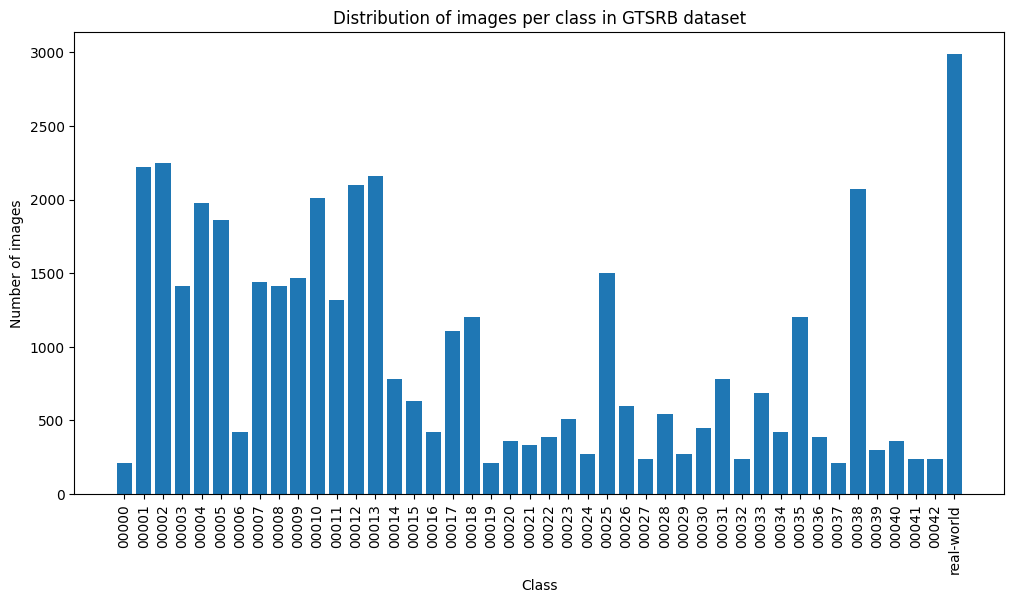

In [48]:
# Count the number of images per class
class_counts = Counter([label for _, label in tqdm(dataset)])

# Get class names from the dataset
class_names = [dataset.classes[idx] for idx in class_counts.keys()]

# Plot the distribution of images per class
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of images per class in GTSRB dataset')
plt.xticks(rotation=90)
plt.show()

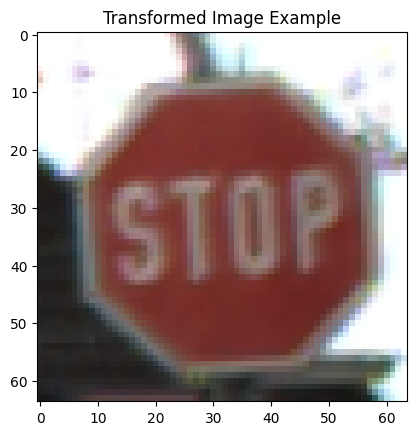

In [49]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5  # Unnormalize
    plt.imshow(image)
    plt.title('Transformed Image Example')
    plt.show()
    
example_image, _ = train_dataset[0]
show_image(example_image)

### Training & Evaluation

In [50]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

if model_type == 'resnet':
    num_epochs = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize the model, loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
# Training loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        if model_type == 'vit':
            outputs = model(images).logits
        else:
            outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.2%}')

100%|█████████████████████████████████████████████████████████████████████████████████▊| 527/528 [00:47<00:00, 10.53it/s]/home/ice1187/car-final/pyenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████████████████████████████████████████████████████████████████████████████| 528/528 [00:47<00:00, 11.10it/s]


Epoch 1/5, Loss: 2.3282, Accuracy: 32.36%


100%|██████████████████████████████████████████████████████████████████████████████████| 528/528 [00:50<00:00, 10.46it/s]


Epoch 2/5, Loss: 0.4252, Accuracy: 86.60%


100%|██████████████████████████████████████████████████████████████████████████████████| 528/528 [00:50<00:00, 10.47it/s]


Epoch 3/5, Loss: 0.2648, Accuracy: 93.24%


100%|██████████████████████████████████████████████████████████████████████████████████| 528/528 [00:50<00:00, 10.47it/s]


Epoch 4/5, Loss: 0.1395, Accuracy: 96.59%


100%|██████████████████████████████████████████████████████████████████████████████████| 528/528 [00:50<00:00, 10.46it/s]

Epoch 5/5, Loss: 0.2114, Accuracy: 95.12%


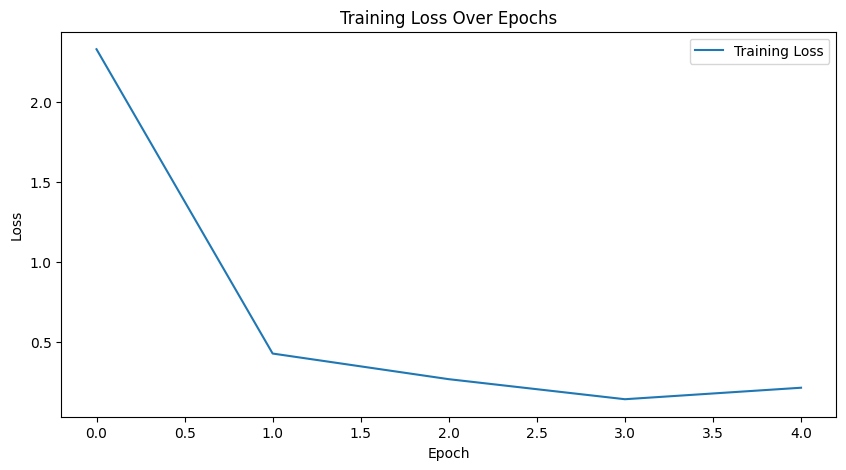

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [53]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        if model_type == 'vit':
            outputs = model(images).logits
        else:
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.98it/s]

Accuracy: 95.63%


In [54]:
if use_real_data:
    torch.save(model, f'model/{model_type}-real-{datetime.now()}.pth')
else:
    torch.save(model, f'model/{model_type}-{datetime.now()}.pth')

### Attack
- patch size
- patch position
- patch transparency (alpha)

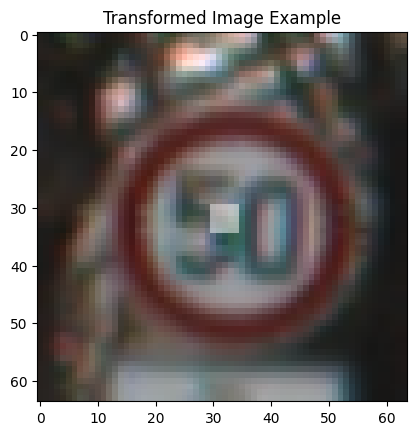

In [55]:
def add_white_rectangle(image, rect_size=(5, 5), position=(30, 30), alpha=0.5):
    image = image.clone()
    for c in range(image.size(0)):  # Iterate over color channels
        image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]] = \
            alpha * 1.0 + (1 - alpha) * image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]]
    return image

example_image, _ = val_dataset[1]
patch_image = add_white_rectangle(example_image)
show_image(patch_image)

In [56]:
# Evaluation after Attack 
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        images = torch.stack([add_white_rectangle(img) for img in images])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {correct / total:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:05<00:00, 26.33it/s]

Accuracy: 84.86%


In [57]:
# Attack: Different Transparecy
model.eval()

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []
for alpha in alphas:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            images = torch.stack([add_white_rectangle(img, alpha=alpha) for img in images])
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'Alpha: {alpha}, Accuracy: {accuracy:.2%}')

100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 26.70it/s]


Alpha: 0.0, Accuracy: 95.63%


100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 26.71it/s]


Alpha: 0.2, Accuracy: 89.76%


100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 26.79it/s]


Alpha: 0.4, Accuracy: 85.97%


100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 26.64it/s]


Alpha: 0.6, Accuracy: 83.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 26.55it/s]


Alpha: 0.8, Accuracy: 81.27%


100%|██████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 26.54it/s]

Alpha: 1.0, Accuracy: 78.98%


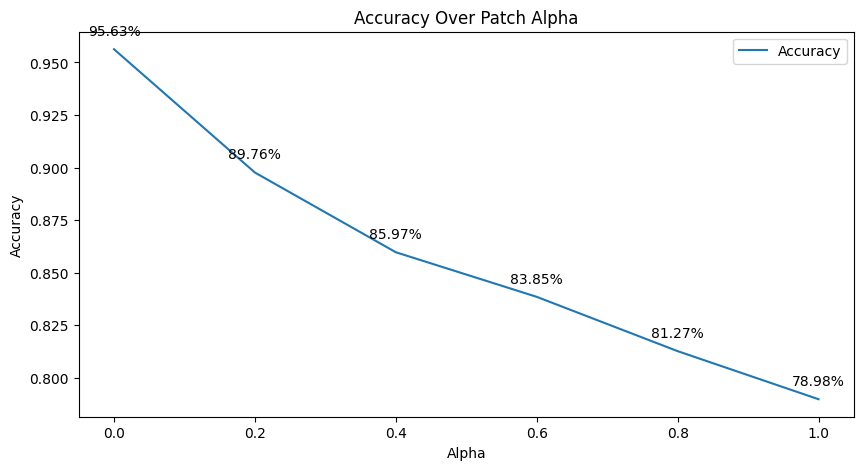

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2%}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()